# Agrupamentos Técnicos de Microrregiões

Este estudo tem o objetivo de explorar as características de Propriedade e Orientação Técnica dos produtores rurais das microrregiões brasileiras.

### fonte de dados: 
<ul>
    <li>
        <a href="https://sidra.ibge.gov.br/tabela/6779"><b>Censo Agropecuário (Tabela 6779):</b></a> Número de estabelecimentos agropecuários, por tipologia, origem da orientação técnica recebida, sexo do produtor, condição do produtor em relação às terras, classe de idade do produtor e escolaridade do produtor.
        <ul>
            <li>Orientação Técnica</li>
            <li>Tipo de Propriedade</li>
        </ul>
    </li>
</ul>

### instalando módulos

### imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA

from scipy.cluster import hierarchy

import matplotlib.pyplot as plt
import plotly.figure_factory as ff

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#scatter 3d
import plotly.express as px
import plotly.offline as pyo

### funções

In [2]:
def corrigir_nomes(nome):
    return nome.strip() \
               .lower() \
               .replace('.', '') \
               .replace('á', 'a') \
               .replace('ã', 'a') \
               .replace('â', 'a') \
               .replace('é', 'e') \
               .replace('í', 'i') \
               .replace('ô', 'o') \
               .replace('ó', 'o') \
               .replace('ç', 'c') \
               .replace('(a)', '') \
               .replace('(o)', '') \
               .replace('(', '') \
               .replace(')', '') \
               .replace(',', '') \
               .replace("-","_") \
               .replace(" ","_") \
               .replace("__","_") \
               .replace("__","_") \
               .replace("__","_") \
               .replace("__","_") \
               .replace("__","_") \
               .replace("__","_")

def cleansing_df(
    p_df: pd.DataFrame,
    p_entidade: str
) -> pd.DataFrame:
    _df = p_df.copy()
    
    _df.columns = [corrigir_nomes(str(r)) for r in _df.columns]
    _df.set_index("microrregiao", inplace=True)
    _df.columns = [p_entidade + "_" + str(r).lower().replace(" ","_") for r in _df.columns]

    for r_col in _df.columns:
        _df[r_col] = _df[r_col].replace("-","0").astype(np.int64)
        _df[r_col].fillna(0, inplace=True)
    
    return _df

def calcula_proporcoes(
    p_df: pd.DataFrame
):
    _df = p_df.copy()
    
    _str_total = "total = " + " + ".join(["_df." + r for r in _df.columns])
    _df = pd.eval(_str_total, target=_df)
    
    for r_col in _df.columns:
        _df[r_col] = _df[r_col] / _df["total"]
        _df[r_col].fillna(0, inplace=True)
    
    _df.drop(columns=["total"], inplace=True)
    
    return _df

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

### tratamento de dados

In [3]:
df_propriedade = pd.read_csv("dados/propriedade.csv", sep=";")
df_propriedade = cleansing_df(
    df_propriedade,
    "propriedade"
)
df_propriedade = calcula_proporcoes(
    df_propriedade
)

df_orientacao = pd.read_csv("dados/orientacao-tecnica.csv", sep=";")
df_orientacao = cleansing_df(
    df_orientacao,
    "orientacao"
)
df_orientacao = calcula_proporcoes(
    df_orientacao
)

### Unindo as Bases

In [4]:
df_inicial = df_propriedade.join(
    df_orientacao
).reset_index()

df_inicial.to_csv('microrregioes_perc_categ.csv')

### Primeira Contemplação:
<ul>
    <li>Temos 17 atributos a serem estudados que representam as características técnicas de cada microrregião.</li>
    <li>Cada atributo representa o percentual de ocorrências diante do total da sua respectiva entidade.</li>
</ul>

In [5]:
df_inicial.head()

microrregiao  propriedade_proprietario  \
0  Fernando de Noronha (PE)                  0.071429   
1               Santos (SP)                  0.809524   
2               Osasco (SP)                  0.552000   
3        Caraguatatuba (SP)                  0.437984   
4      Franco da Rocha (SP)                  0.517787   

   propriedade_concessionario_ou_assentado_aguardando_titulacao_definitiva  \
0                                           0.571429                         
1                                           0.095238                         
2                                           0.232000                         
3                                           0.147287                         
4                                           0.264822                         

   propriedade_arrendatario  propriedade_parceiro  propriedade_comodatario  \
0                  0.000000               0.00000                 0.142857   
1                  0.000000               0.00000                 0.000000   
2                  0.016000               0.08000                 0.048000   
3                  0.112403               0.01938                 0.065891   
4                  0.035573               0.12253                 0.015810   

   propriedade_ocupante  propriedade_produtor_sem_area  orientacao_recebe  \
0              0.000000                       0.214286           0.176471   
1              0.095238                       0.000000           0.233333   
2              0.064000                       0.008000           0.262097   
3              0.205426                       0.011628           0.235955   
4              0.043478                       0.000000           0.230159   

   orientacao_governo_federal_estadual_ou_municipal  \
0                                          0.117647   
1                                          0.133333   
2                                          0.104839   
3                                          0.162921   
4                                          0.121693   

   orientacao_propria_ou_do_proprio_produtor  orientacao_cooperativas  \
0                                   0.000000                 0.000000   
1                                   0.066667                 0.033333   
2                                   0.108871                 0.068548   
3                                   0.047753                 0.019663   
4                                   0.095238                 0.007937   

   orientacao_empresas_integradoras  \
0                          0.000000   
1                          0.033333   
2                          0.004032   
3                          0.000000   
4                          0.000000   

   orientacao_empresas_privadas_de_planejamento  \
0                                      0.000000   
1                                      0.000000   
2                                      0.004032   
3                                      0.014045   
4                                      0.002646   

   orientacao_organizacao_nao_governamental_ong  orientacao_sistema_s  \
0                                      0.000000              0.000000   
1                                      0.000000              0.000000   
2                                      0.076613              0.100806   
3                                      0.002809              0.008427   
4                                      0.010582              0.084656   

   orientacao_outra  orientacao_nao_recebe  
0          0.058824               0.647059  
1          0.033333               0.466667  
2          0.028226               0.241935  
3          0.019663               0.488764  
4          0.007937               0.439153

### Redução de dimensionalidade por PCA
No estudo abaixo podemos verificar que os 3 primeiros componentes já são capazes de representar mais de 80% da variância dos dados.

In [6]:
n_pca = 0
pca = PCA(n_components=12)
pca.fit(df_inicial.drop(columns=["microrregiao"]))
df_reduzido = pd.DataFrame(pca.transform(df_inicial.drop(columns=["microrregiao"])))
df_reduzido.columns = ["comp" + str(r) for r in df_reduzido.columns]
#df_reduzido.drop(columns=["comp2"], inplace=True)

df_reduzido["microrregiao"] = df_inicial["microrregiao"]

#print("explained_variance_", pca.explained_variance_)
#print("explained_variance_ratio_", pca.explained_variance_ratio_)

#definir o número de componentes baseado em 99% de variabilidade dos dados das variáveis originais
for _i, _r in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    if _r.round(2) >= 0.99:
        n_pca = _i + 1
        break
        
print("Selecionados os", n_pca, "primeiros componentes de", len(pca.explained_variance_ratio_))
print(np.cumsum(pca.explained_variance_ratio_))

_componentes = ["comp" + str(_i) for _i in range(0, n_pca)]

df_reduzido[["microrregiao"] + _componentes].head(5)

df_reduzido[["microrregiao"] + _componentes].to_csv('microrregioes_componentes.csv') #export do resultado de PCA

Selecionados os 9 primeiros componentes de 12
[0.66384986 0.85575086 0.90250791 0.93208465 0.95358579 0.96580502
 0.97683971 0.98487511 0.99190568 0.99703591 0.99845252 0.99918753]


### Variabilidade Acumulada por Componente

In [7]:
_test_var = True
_check = '✓'
_n_check = 'x'
_print_check = _check
print('Variabilidade acumulda dos componentes:')
for _i, _var in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    
    print(_print_check, 'comp' + str(_i), _var)
    
    if _var >= 0.99:
        _test_var_99 = False
        _print_check = _n_check

Variabilidade acumulda dos componentes:
✓ comp0 0.6638498604315493
✓ comp1 0.8557508553311464
✓ comp2 0.9025079083994503
✓ comp3 0.9320846503814072
✓ comp4 0.9535857908833545
✓ comp5 0.9658050240601912
✓ comp6 0.9768397065213729
✓ comp7 0.9848751094018252
✓ comp8 0.9919056752336638
x comp9 0.9970359058893007
x comp10 0.9984525169713752
x comp11 0.9991875290745869


### k-means (estimando o número ideal de clusters baseado no Método Cotovelo - Elbow Method - WSS - within-clusters sum-of-squares)
No estudo abaixo podemos verificar o número ideal de clusters.

O número ideal de clusters é: 7


Text(c7, 16.9940757326525, 'best wss')

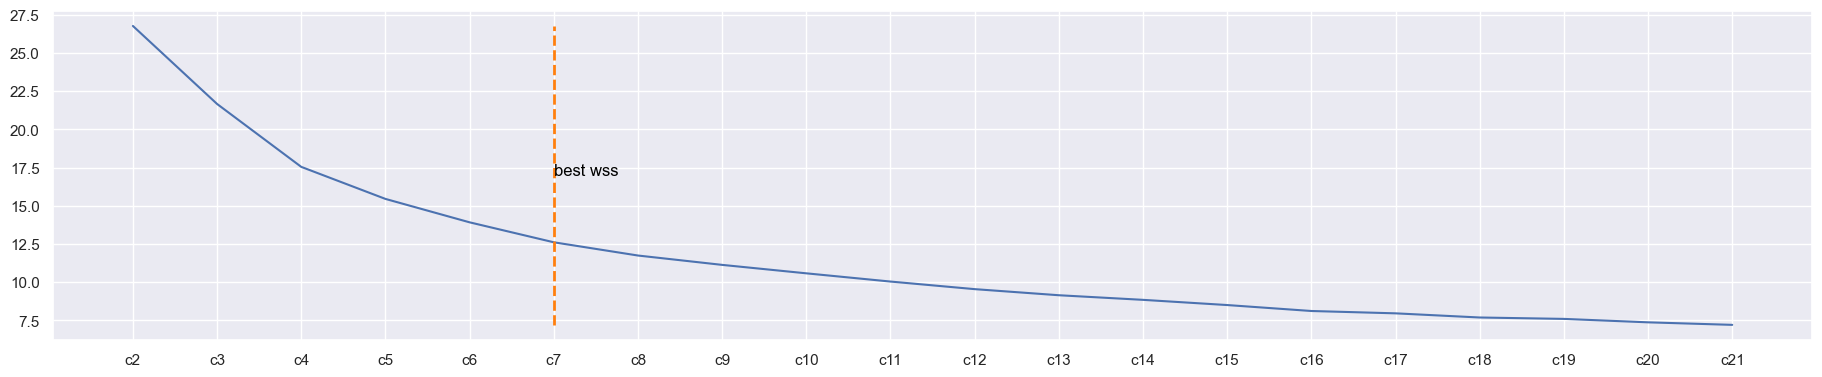

In [8]:
from math import *

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

wss = []

df_input = df_reduzido.drop(columns=["microrregiao"])[_componentes]

# Notice you start at 2 clusters for silhouette coefficient

l_max_cluster_numbers = 22

for _k in range(2, l_max_cluster_numbers):
    kmeans = KMeans(
        init="random",
        n_clusters=_k,
        n_init=25,
        max_iter=1000,
        random_state=33
    )
    kmeans.fit(df_input)
    wss.append(kmeans.inertia_)

l_best_n_clusters = optimal_number_of_clusters(wss)

#l_best_n_clusters = list(silh).index(np.min(silh))
print("O número ideal de clusters é:", l_best_n_clusters)

sns.set(rc={'figure.figsize':(22.7,4.27)})
_cluster_name_list = ["c" + str(_r) for _r in range(2,l_max_cluster_numbers)]

g = sns.lineplot(x=_cluster_name_list,y=wss)

l_cluster_str = 'c' + str(l_best_n_clusters)

g.vlines(x=l_cluster_str, ymin=np.min(wss), ymax=np.max(wss), colors=['tab:orange', 'tab:blue'], ls='--', lw=2)
plt.text(x=l_cluster_str, y=(np.max(wss)+np.min(wss))/2, s = 'best wss', color='black')

### k-means (segregação das microrregiões em clusters de acordo com o número ideal de clusters estipulado)

In [9]:
kmeans = KMeans(
    init="random",
    n_clusters=l_best_n_clusters,
    n_init=25,
    max_iter=1000,
    random_state=33
)

kmeans.fit(df_reduzido.drop(columns=["microrregiao"]))

df_resultado = df_reduzido.copy()
df_resultado["cluster"] = kmeans.labels_
df_resultado["cluster"] = df_resultado["cluster"] + 1
df_resultado["cluster"] = df_resultado["cluster"].map(lambda x: "cluster" + str(x).zfill(2))

df_clusters_group = df_resultado.groupby(["cluster"]).agg(count=("cluster", "count")).reset_index().sort_values(by=["count"], ascending=False)
#pd.concat([df_clusters_group.head(), df_clusters_group.tail()])

df_resultado["qtd"] = df_resultado.groupby("cluster")["cluster"].transform(np.count_nonzero)
df_resultado.sort_values(by=["qtd"], inplace=True)
df_resultado.drop(columns=["qtd"], inplace=True)

df_validacao = df_resultado[["microrregiao","cluster"]].set_index("microrregiao").join(df_inicial.set_index("microrregiao")).reset_index()

### Contemplação
Como resultado desse estudo preliminar temos as seguintes aglomerações técnicas das microrregiões.

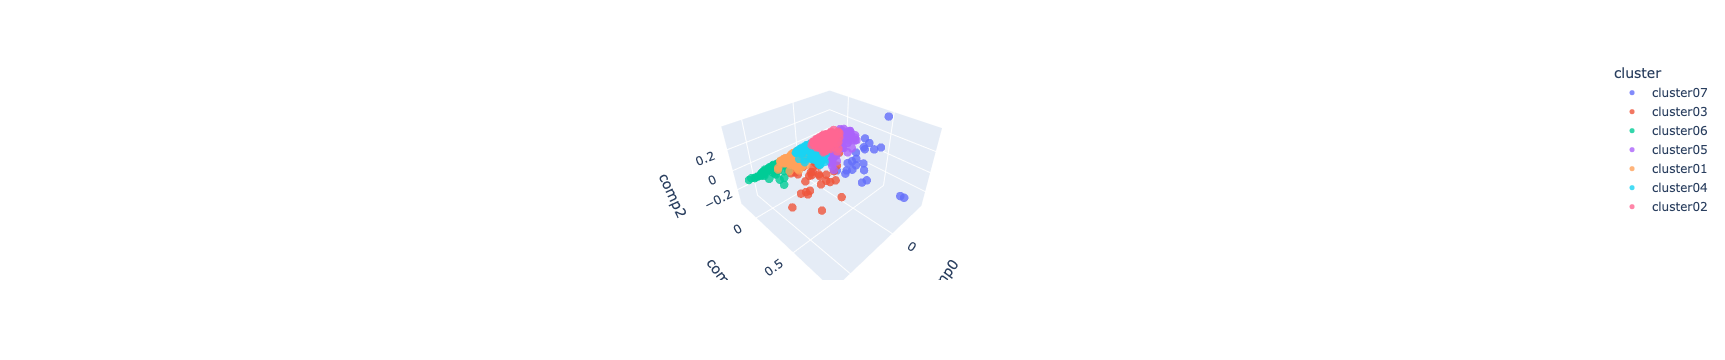

In [10]:
pyo.init_notebook_mode()

fig = px.scatter_3d(
    df_resultado, 
    x='comp0',
    y='comp1',
    z='comp2',
    hover_name='microrregiao',
    color='cluster',
    opacity=0.8,
    width=1000, height=300
)

fig.update_traces(marker_size = 5)
fig.show()

## Contemplação das características de cada cluster

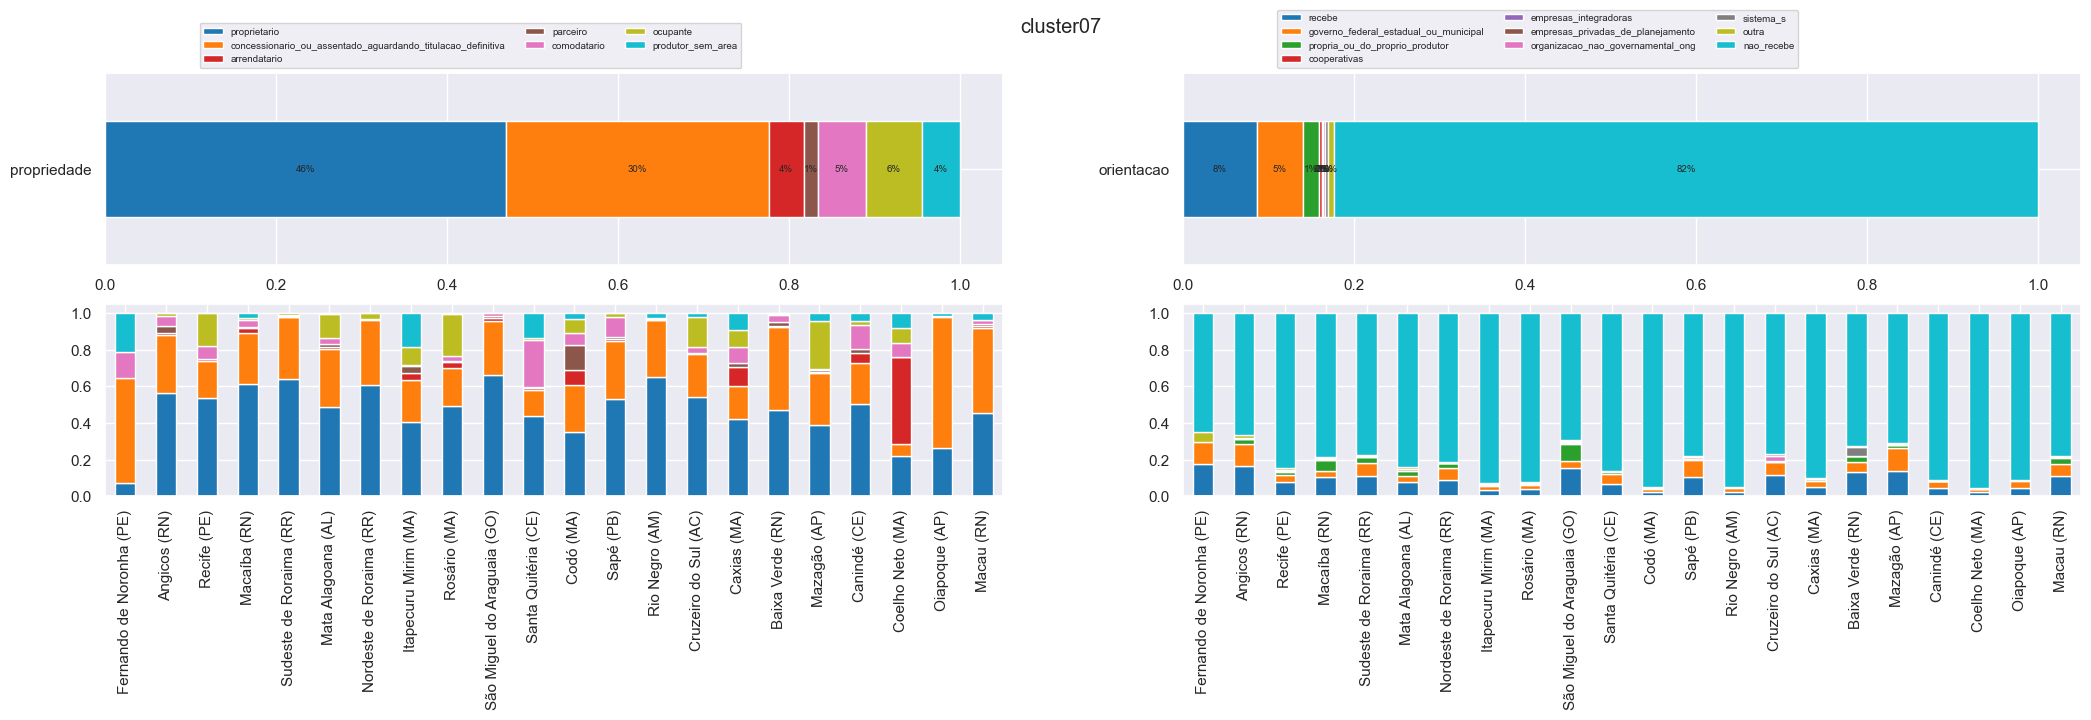

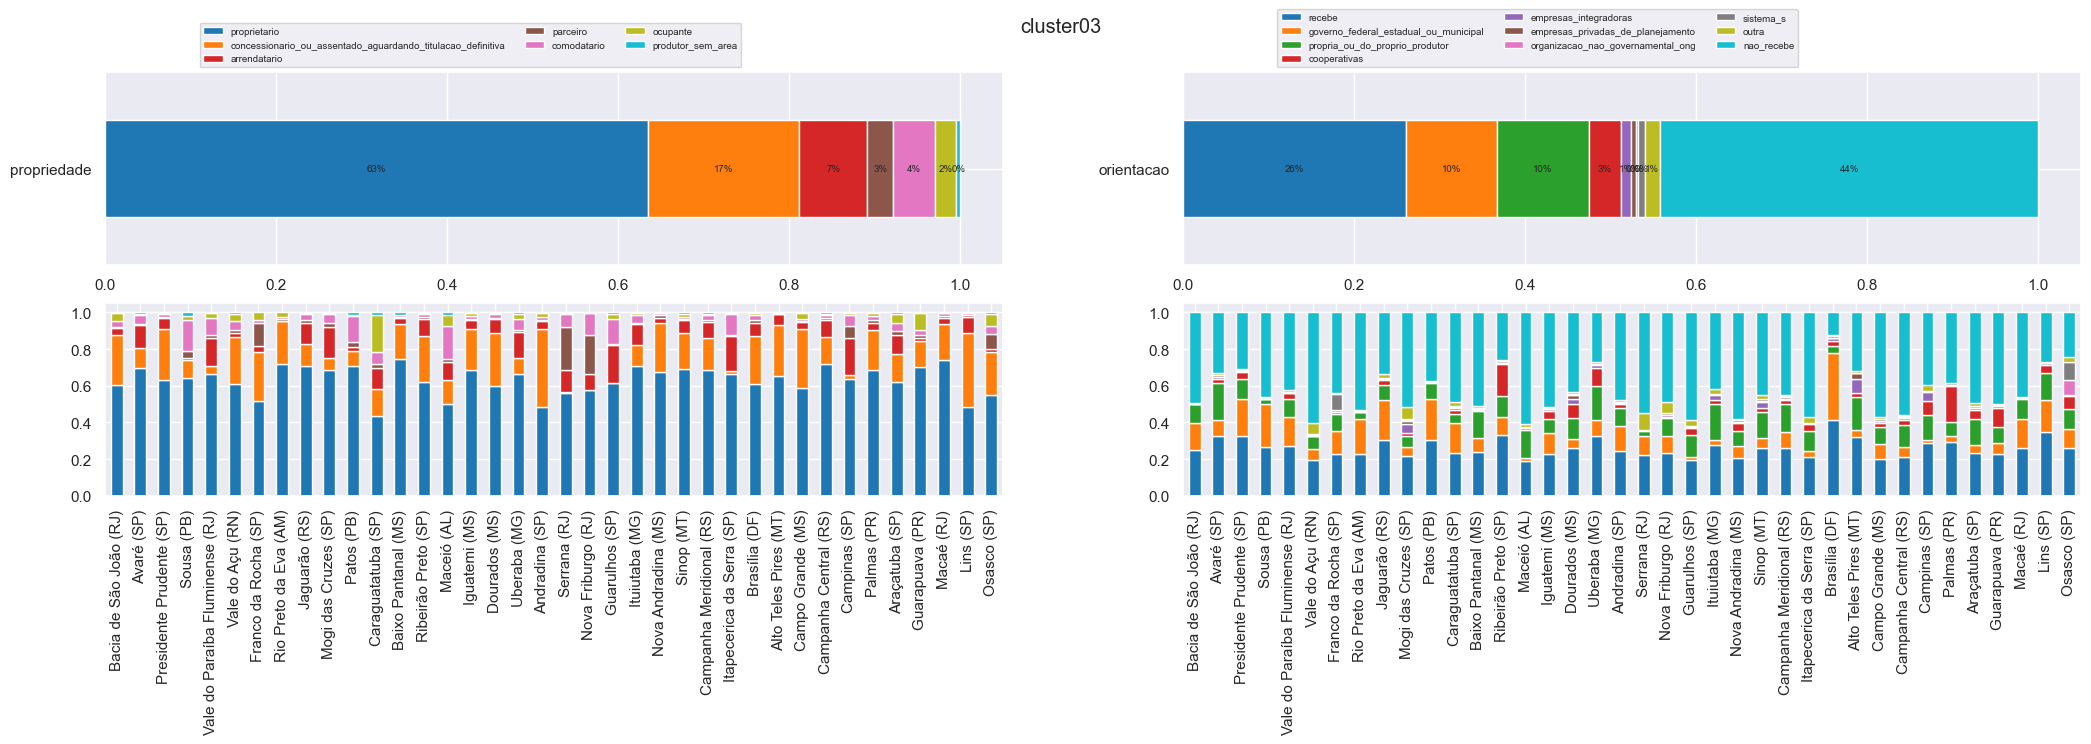

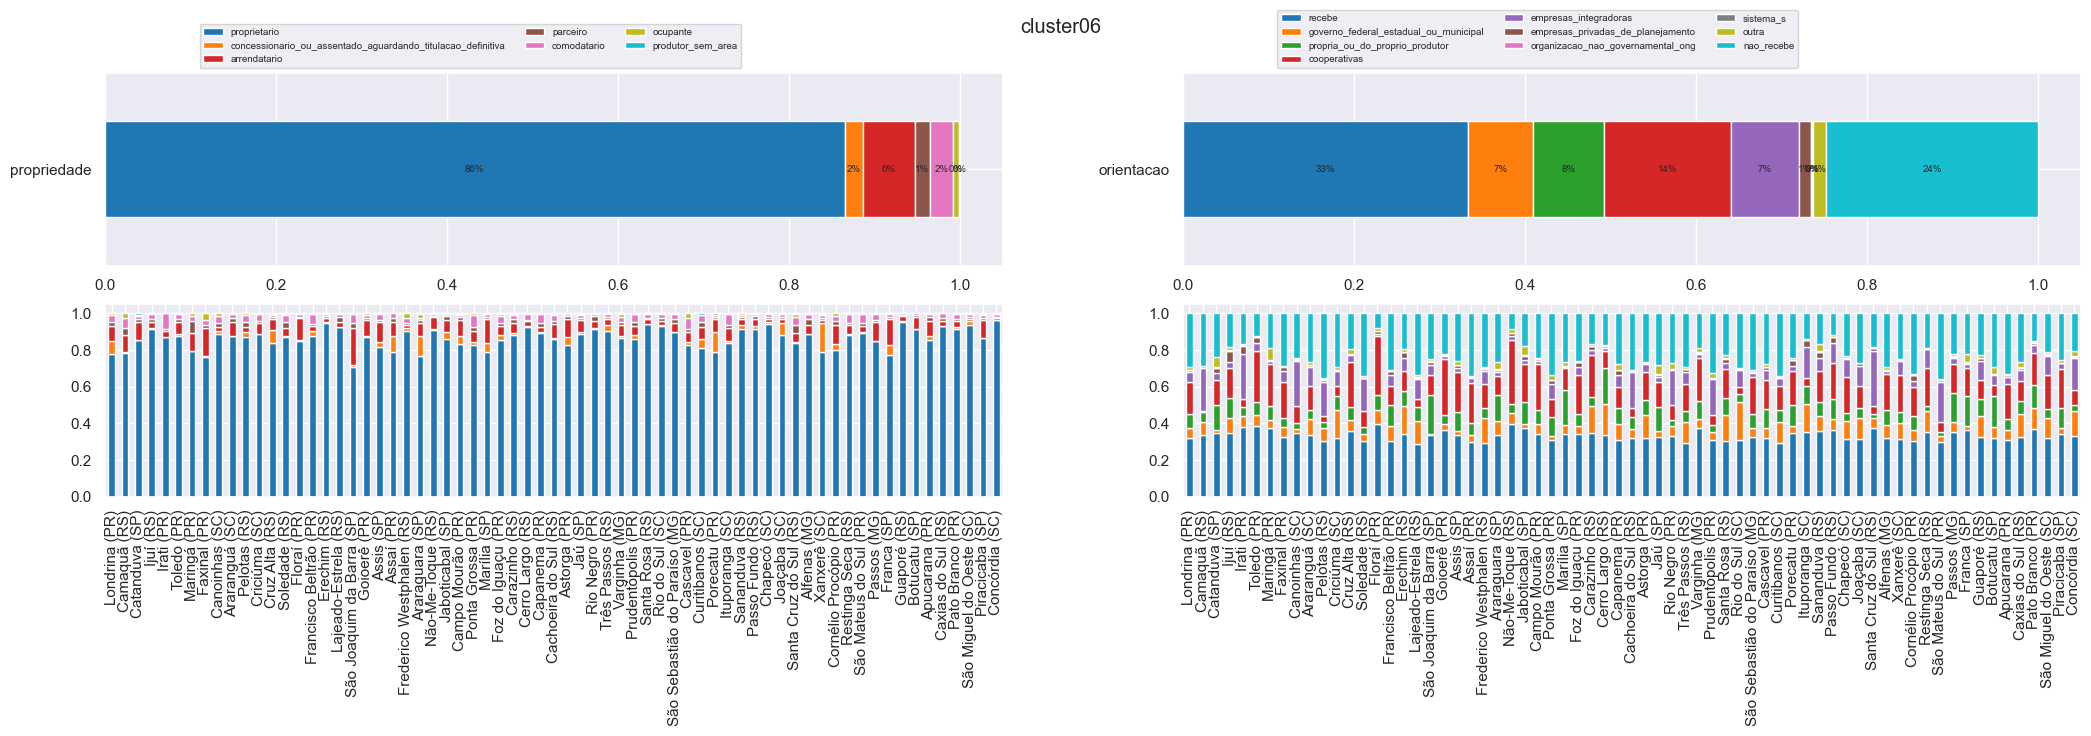

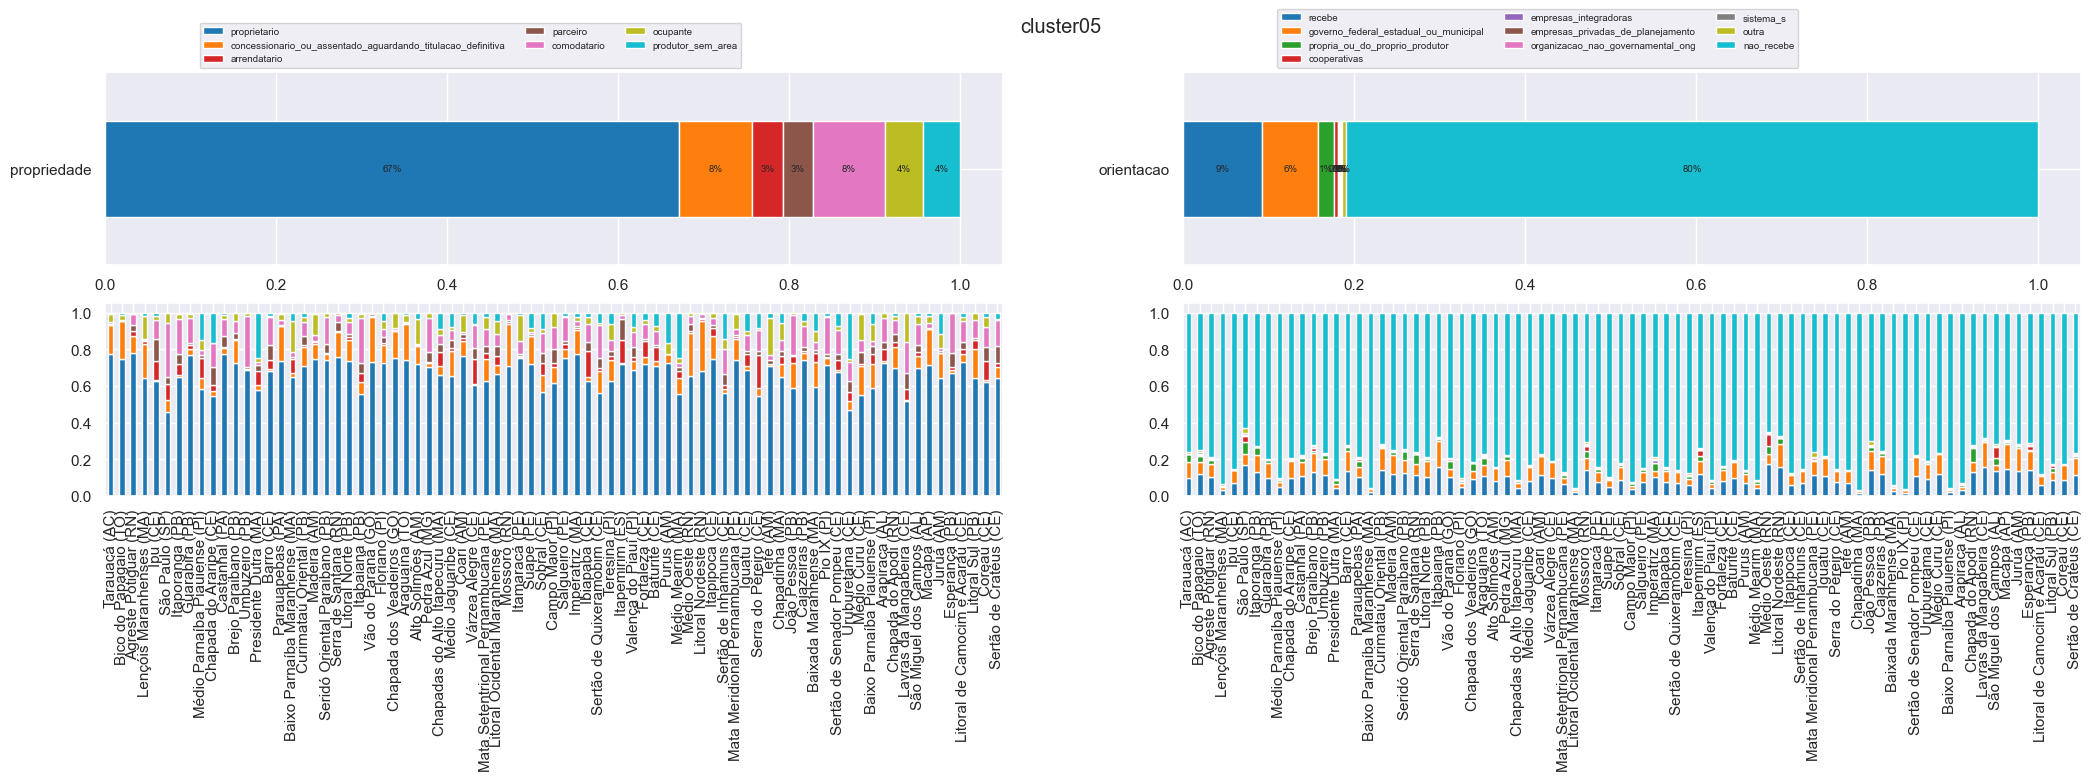

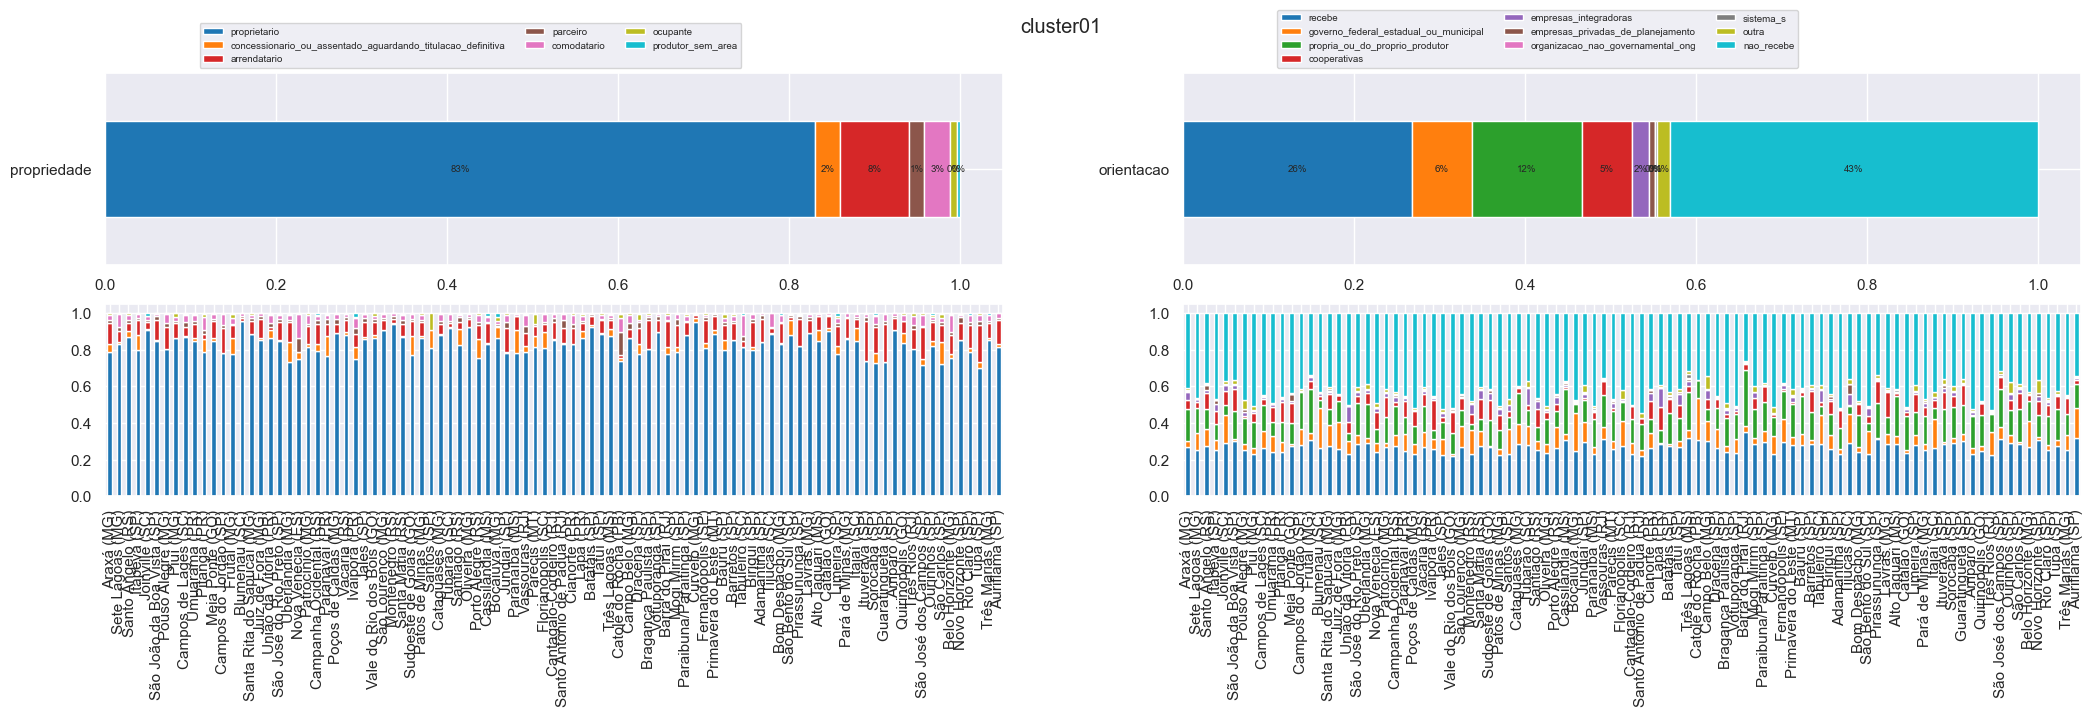

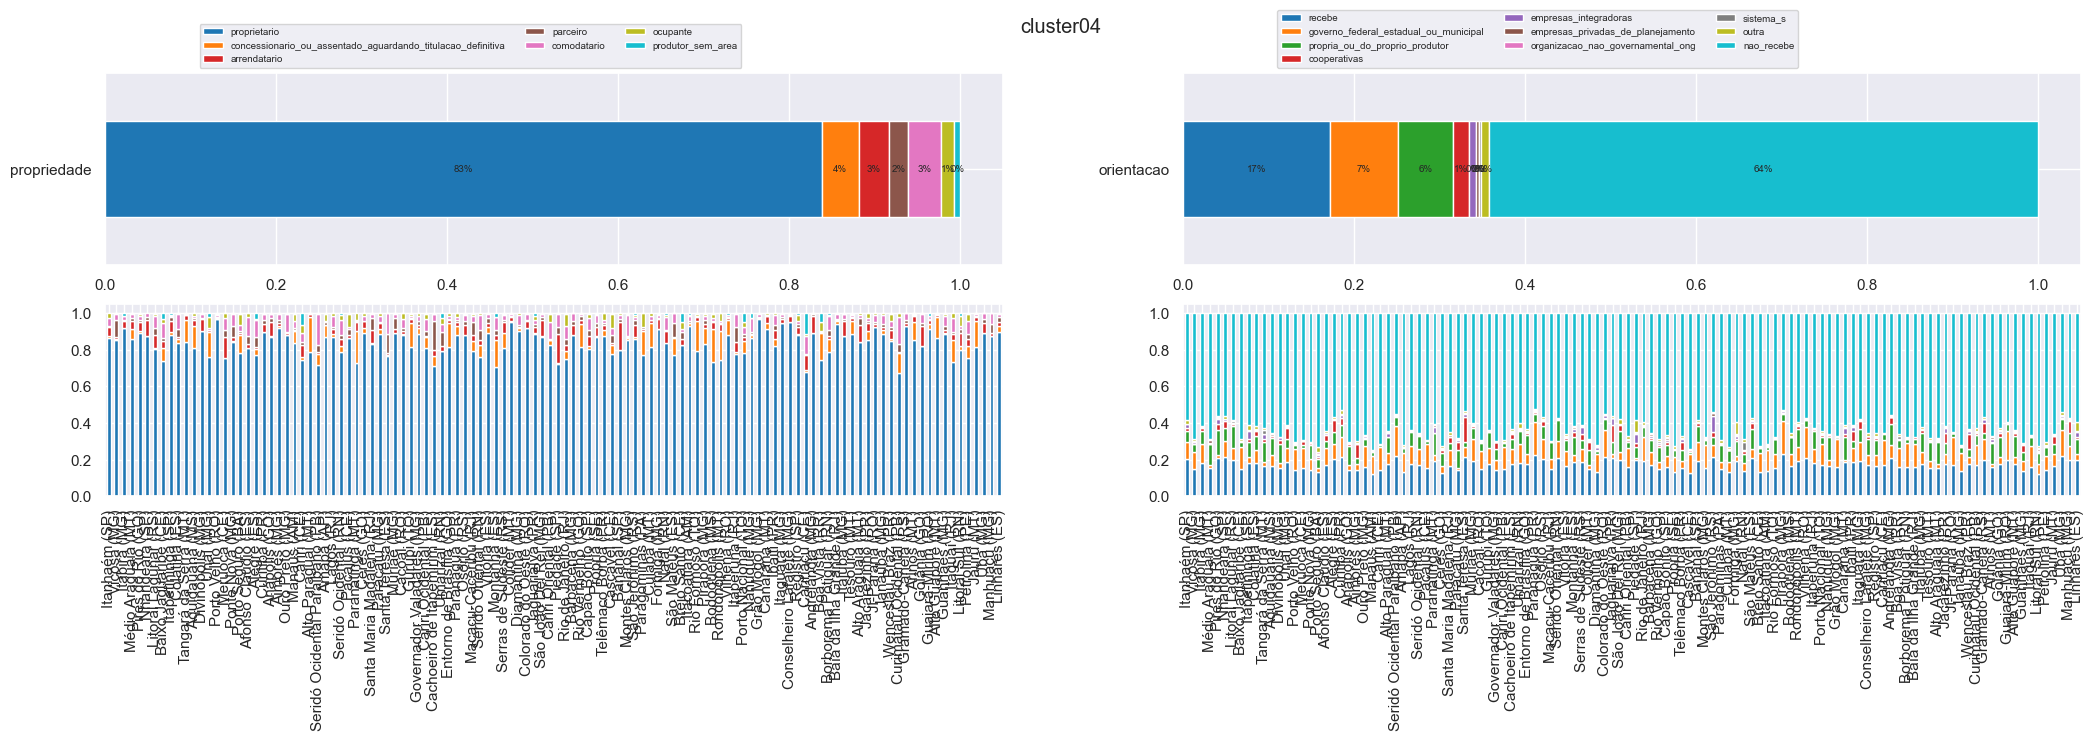

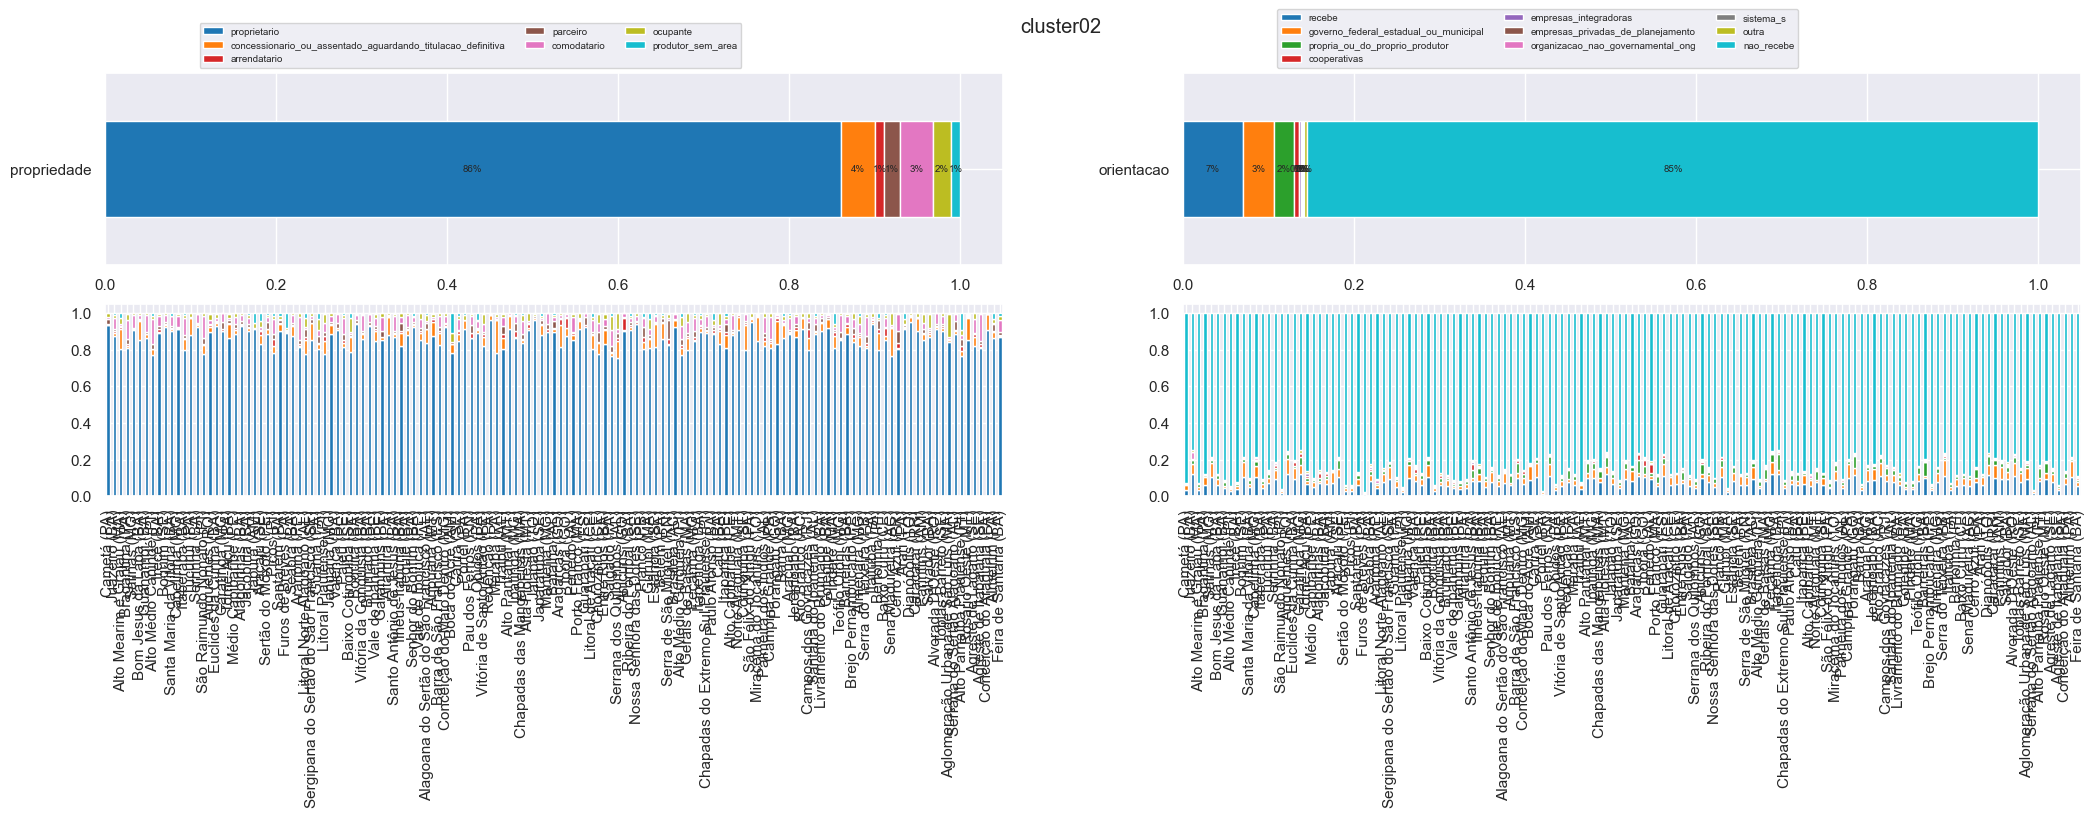

In [11]:
l_dict_colecao_metricas = {
    'propriedade': [
        'propriedade_proprietario',
        'propriedade_concessionario_ou_assentado_aguardando_titulacao_definitiva',
        'propriedade_arrendatario',
        'propriedade_parceiro',
        'propriedade_comodatario',
        'propriedade_ocupante',
        'propriedade_produtor_sem_area'
    ],
    'orientação': [
        'orientacao_recebe',
        'orientacao_governo_federal_estadual_ou_municipal',
        'orientacao_propria_ou_do_proprio_produtor',
        'orientacao_cooperativas',
        'orientacao_empresas_integradoras',
        'orientacao_empresas_privadas_de_planejamento',
        'orientacao_organizacao_nao_governamental_ong', 
        'orientacao_sistema_s',
        'orientacao_outra', 
        'orientacao_nao_recebe'
    ]
}

for r_cluster in df_validacao['cluster'].drop_duplicates():
    
    fig, ax = plt.subplots(2, 2, figsize=(25.5, 5.5))
    fig.suptitle(r_cluster)
    
    # Dados ###################################################################################
    df_cluster = df_validacao[df_validacao['cluster'] == r_cluster]
    df_cluster.drop(columns=['cluster'], inplace=True)

    #propriedade
    df_cluster_propriedade = df_cluster[['microrregiao'] + l_dict_colecao_metricas['propriedade']]
    df_cluster_propriedade = df_cluster_propriedade.set_index(['microrregiao'])

    for r_column in df_cluster_propriedade.columns:
        df_cluster_propriedade.rename(columns={r_column: r_column.replace('propriedade_', '')}, inplace=True)

    df_cluster_propriedade_unpivot = df_cluster_propriedade.reset_index().melt(id_vars=['microrregiao'], var_name='propriedade', value_name='percentual')
    df_cluster_propriedade_unpivot = df_cluster_propriedade_unpivot.sort_values(by=['microrregiao', 'percentual'], ascending=False)

    #orientação
    df_cluster_orientacao = df_cluster[['microrregiao'] + l_dict_colecao_metricas['orientação']]
    df_cluster_orientacao = df_cluster_orientacao.set_index(['microrregiao'])

    for r_column in df_cluster_orientacao.columns:
        df_cluster_orientacao.rename(columns={r_column: r_column.replace('orientacao_', '')}, inplace=True)

    df_cluster_orientacao_unpivot = df_cluster_orientacao.reset_index().melt(id_vars=['microrregiao'], var_name='orientacao', value_name='percentual')
    df_cluster_orientacao_unpivot = df_cluster_orientacao_unpivot.sort_values(by=['microrregiao', 'percentual'], ascending=False)
    
    # Propriedade #############################################################################
    df_pizza_propriedade = df_cluster_propriedade.copy()
    df_pizza_propriedade['chave'] = 'propriedade'
    df_pizza_propriedade = df_pizza_propriedade.groupby(['chave']).agg('mean')
    
    #distribuição valores de propriedade
    df_pizza_propriedade.plot(
        ax=ax[0][0],
        kind='barh', 
        stacked=True,
        xlabel='',
        ylabel='',
        cmap='tab10'
    )
    
    #legenda
    ax[0][0].legend(ncol=3, prop={'size': 7}, bbox_to_anchor=(0.1, 1.0))
    
    #valores percentuais na barra superior de propriedade
    labels = [r for r in df_pizza_propriedade.values[0]]
    for _i, _c in enumerate(ax[0][0].containers):
        ax[0][0].bar_label(_c,
            label_type='center',
            labels = [str(int(labels[_i]* 100)) + '%'],
            size = 7
        )
    
    #distribuição valores de propriedade em cada microrregião
    df_cluster_propriedade.plot(
        ax=ax[1][0],
        kind='bar', 
        stacked=True,
        xlabel='',
        ylabel='',
        legend=False,
        cmap='tab10'
    )
    
    # Orientação ##############################################################################
    df_pizza_orientacao = df_cluster_orientacao.copy()
    df_pizza_orientacao['chave'] = 'orientacao'
    df_pizza_orientacao = df_pizza_orientacao.groupby(['chave']).agg('mean')
    
    #distribuição valores de orientação
    df_pizza_orientacao.plot(
        ax=ax[0][1],
        kind='barh', 
        stacked=True,
        xlabel='',
        ylabel='',
        cmap='tab10'
    )
    
    #legenda
    ax[0][1].legend(ncol=3, prop={'size': 7}, bbox_to_anchor=(0.1, 1.0))
    
    #valores percentuais na barra superior de orientação
    labels = [r for r in df_pizza_orientacao.values[0]]
    for _i, _c in enumerate(ax[0][1].containers):
        ax[0][1].bar_label(_c,
            label_type='center',
            labels = [str(int(labels[_i]* 100)) + '%'],
            size = 7
        )
    
    #distribuição valores de orientação em cada microrregião
    df_cluster_orientacao.plot(
        ax=ax[1][1],
        kind='bar', 
        stacked=True,
        xlabel='',
        ylabel='',
        legend=False,
        cmap='tab10'
    )